In [3]:
! pip install pydub tensorflow-io

  Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
  Obtaining dependency information for tensorflow-io from https://files.pythonhosted.org/packages/64/d3/d806a5084dab0bdea5a723f7242a4a230765aa92bac5bb7a66b7a4f06119/tensorflow_io-0.33.0-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 8.4 MB/s eta 0:00:000m eta 0:00:010:00:01


In [2]:
import tensorflow_datasets as tfds
(dataset_train_original, dataset_validate_original), info = tfds.load(
    "spoken_digit",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True
)
info

/home/apakiman/Projects/dsr-b35/dsr-cv/envs/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-25 13:55:13.194634: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-25 13:55:13.195741: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU

tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='/home/apakiman/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_class

2023-08-25 13:55:16.485316: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


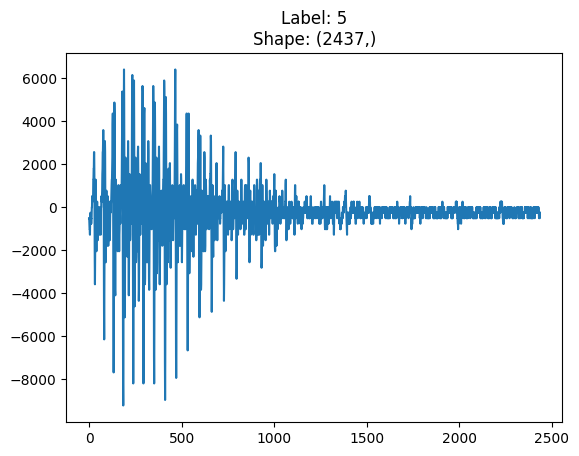

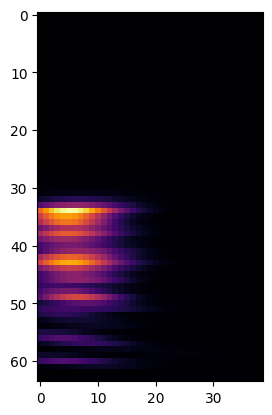

In [3]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
from  IPython.display import Audio, display

for audio, label in dataset_train_original.shuffle(100).take(1):
    audio = audio.numpy().astype(np.float32)
    plt.plot(audio)
    plt.title(f"Label: {label}\nShape: {audio.shape}")
    plt.show()

    display(Audio(audio, rate=8000))

    mel = librosa.feature.melspectrogram(
    y=audio, n_mels=64, hop_length=64,
    sr=8000
    )   
    plt.imshow(mel[::-1, :], cmap="inferno")  # flipping why axis to have low freq on the buttom
    plt.show()

2023-08-25 14:27:47.725924: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


tf.Tensor(2, shape=(), dtype=int64)


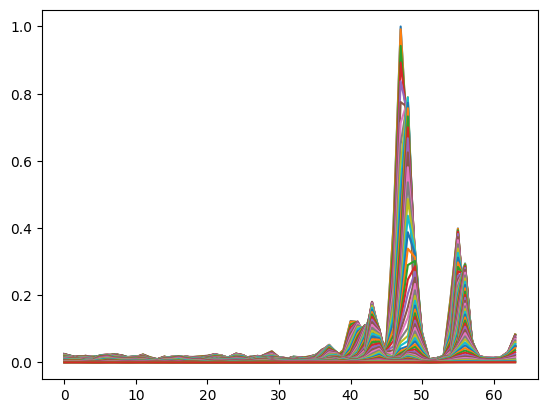

In [52]:
import tensorflow as tf
import tensorflow_io as tfio

def preprocess(audio, label):

    audio = tf.cast(audio, tf.float32)/32768.0 # typecasting, and normalizing
    spectrogram = tfio.audio.spectrogram(
        audio, nfft=1024, window=1024, stride=64
    )
    spectrogram = tfio.audio.melscale(spectrogram, rate=8000, mels=64, fmin=0, fmax=2000)
    spectrogram /= tf.math.reduce_max(spectrogram) #normalization
    spectrogram = tf.expand_dims(spectrogram, axis=-1) #going 3D for conv2d
    spectrogram = tf.image.resize(spectrogram, (64, 64)) # Resize it for ANN
    spectrogram = tf.transpose(spectrogram, perm=(1, 0, 2)) # swap axis, time to frequency
    spectrogram = spectrogram[::-1, :, :] # make frequency upside down


    return spectrogram, label

dataset = dataset_train_original.map(lambda audio, label: preprocess(audio, label))

for x, y in dataset.take(1):
    plt.plot(x[:,:,0])
    print(y)

tf.Tensor(9, shape=(), dtype=int64)


2023-08-25 14:27:43.565092: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


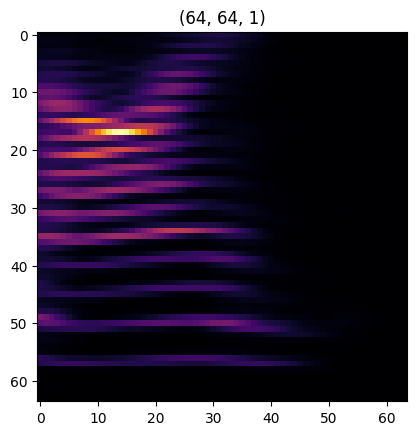

In [51]:
for x, y in dataset.shuffle(100).take(1):
    plt.imshow(x, cmap="inferno")
    plt.title(f"{x.shape}")
    print(y)

In [53]:
dataset_train = dataset_train_original.map(lambda audio, label: preprocess(audio, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(10000)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda audio, label: preprocess(audio, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)

In [71]:
from tensorflow.keras import models, layers

model = models.Sequential([
    layers.Conv2D(4, (3,3), padding="same", activation="relu", input_shape=(64, 64,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(8, (3,3), padding="same", activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, 
    epochs=50,
    validation_data=dataset_validate,
    verbose=0

)
np.max(history.history["val_accuracy"])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 64, 64, 4)         40        
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 4)         0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 8)         0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 64)               

In [72]:
np.max(history.history["val_accuracy"])

0.9599999785423279